In [1]:
!pip install ppi-python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ppi_py
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
def build_fit_slr(x,y):
    """
    y_hat = model.predict(x)
    """
    model = LinearRegression()
    model.fit(x,y)
    return model

In [4]:
def build_fit_dt(x,y):
    """
    y_hat = model.predict(x)
    """
    model = DecisionTreeRegressor()
    model.fit(x,y)
    return model

In [5]:
def build_fit_rf(x,y):
    """
    y_hat = model.predict(x)
    """
    model = RandomForestRegressor()
    model.fit(x,y)
    return model

Rho - correlation between x, y = mx + e
e ~ N(0, s(rho)*x)

In [6]:
def sample_y_linear(x, m, beta, rho):
    """
    Given a sample of X, we generate Y as a linear function (SLR).
    """

    # compute sigma squared
    #sigma_squared = (beta**2)*gamma*(1.-rho)/rho
    sigma_squared = abs(m)*beta*(1.-(rho**2))/(rho**2)

    # sample noise (e_i)
    sampled_e = np.random.normal(loc=0,
                                 scale=sigma_squared*x,
                                 size=x.shape
                                 )

    # compute y as a linear function of x
    y = m*x + sampled_e

    return y


In [7]:
def sample_gamma_population(alpha,
                            beta,
                            sample_size,
                            m,
                            rho = None
                            ):
    """
    Sample <sample_size> instances, x_i ~ G(alpha, gamma)

    Then creates y_i ~ beta*x_i + e_i,
      where e_i ~ N(0, sigma^2_e*x_i), where
      sigma^2_e = (beta^2)gamma[(1-r^2)/)r^2]
      for rho(x_i, y_i) = r ==> desired correlation
    """

    assert np.any(rho != 0), "rho must be different from 0"

    # sample x
    x = np.random.gamma(alpha, beta, sample_size)

    # sample y
    y = sample_y_linear(x, m, beta, rho)

    return x, y



In [8]:
def f_wesley(xbar_star, ybar_star, x):
    """
    implementation of f, as defined by pdf.
    f(x_i) = \frac{\bar{Y}^{*}}{\bar{X}^{*}}(x_i)
    """
    assert np.any(xbar_star != 0), "xbar_star must be different from 0"

    return ybar_star*x/xbar_star



In [9]:
def ratio_estimator_mean(x_bar_unlabelled, x_bar_labelled, y_bar_labelled):
    """
    As defined in the pdf.
    """
    assert np.any(x_bar_labelled != 0), "x_bar_labelled must be different from 0"
    return x_bar_unlabelled*y_bar_labelled/x_bar_labelled

In [10]:
def ratio_estimator_variance(x_u, x_l, y_l, dof=1):
    """
    as defined from Sampling Theory and Practice (quite complete),
    p97 linearization

    Note, we use 1 degree of freedom for sample variance computation
    """
    # (xbar_tilde**2 / x_bar**2)(1- n/N)(var_y**2, + R^2var_x**2 - 2R*covar(x,y))

    # sample sizes
    x_u = x_u.reshape(1, -1)
    x_l = x_l.reshape(1, -1)
    y_y = y_l.reshape(1, -1)
    n = x_l.shape[1]
    N = x_u.shape[1]

    # means
    mu_x_u = x_u.mean(axis=1)
    x_l_mean = x_l.mean(axis=1)
    y_l_mean = y_l.mean(axis=1)
    r_hat = y_l_mean/x_l_mean

    # variances
    x_sample_var = np.var(x_l, axis=1, ddof=dof)
    y_sample_var = np.var(y_l, axis=1, ddof=dof)
    xy_covar = np.array([np.cov(x_l[i], y_l[i], ddof=dof)[0,1] for i in range(x_l.shape[0])])

    # implement term by term, treat the (1-n/N)*)(1/n) as one term
    term_one = (mu_x_u**2)/(x_l_mean**2)
    term_two = (1.0 - float(n/N))/n
    term_three = y_sample_var**2 + (r_hat**2)*(x_sample_var**2) - 2*r_hat*xy_covar

    variance = term_one*term_two*term_three
    return variance

In [11]:
def mean_absolute_bias(thetas, true_mean):
    """
    For B experimental repeats, computes the mean absolute error (mean bias error)
    across all B experiments.
    """
    errors = thetas - true_mean
    errors = abs(errors)
    errors = errors.reshape(1, -1)
    return np.mean(errors, axis=1)



In [12]:
#################
# constants
#################

# first population
ALPHA_1 = 1.0
GAMMA_1 = 2.0
# second population
ALPHA_2 = 1.4
GAMMA_2 = 1.6


# Y relationship
RHO = 0.4
BETA = 3.2

# data generation sizes
N_TRAIN = 5000
n = 300
N = 10000

# Expected value of X both distributions
EXPECTED_FIRST_DISTRIBUTION_MEAN_X = ALPHA_1*GAMMA_1
EXPECTED_SECOND_DISTRIBUTION_MEAN_X = ALPHA_2*GAMMA_2

# Expected value of Y both distributions (via Wesley formula)
EXPECTED_FIRST_DISTRIBUTION_MEAN_Y = (BETA**3)*(ALPHA_1**2)*(GAMMA_1**2)/(RHO**2)
EXPECTED_SECOND_DISTRIBUTION_MEAN_Y = (BETA**3)*(ALPHA_2**2)*(GAMMA_2**2)/(RHO**2)


print("TRUE MEAN OF 1st X distribution: ", EXPECTED_FIRST_DISTRIBUTION_MEAN_X)
print("TRUE MEAN OF 2nd X distribution: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X)

print("EXPECTED VALUE OF 1ST Y DISTRIBUTION (SIMPLE MULTIPLICATION): ", EXPECTED_FIRST_DISTRIBUTION_MEAN_X*BETA)
print("EXPECTED VALUE OF 2ND Y DISTRIBUTION (SIMPLE MULTIPLICATION): ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)

print("EXPECTED VALUE OF 1ST Y DISTRIBUTION (WESLEY EQUATION): ", EXPECTED_FIRST_DISTRIBUTION_MEAN_Y)
print("EXPECTED VALUE OF 2ND Y DISTRIBUTION (WESLEY EQUATION): ", EXPECTED_SECOND_DISTRIBUTION_MEAN_Y)



# Expected value of Y
EXPECTED_TRUE_MEAN = EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA

TRUE MEAN OF 1st X distribution:  2.0
TRUE MEAN OF 2nd X distribution:  2.2399999999999998
EXPECTED VALUE OF 1ST Y DISTRIBUTION (SIMPLE MULTIPLICATION):  6.4
EXPECTED VALUE OF 2ND Y DISTRIBUTION (SIMPLE MULTIPLICATION):  7.167999999999999
EXPECTED VALUE OF 1ST Y DISTRIBUTION (WESLEY EQUATION):  819.2
EXPECTED VALUE OF 2ND Y DISTRIBUTION (WESLEY EQUATION):  1027.6044800000002


_________________________________
Let's do some playing
________________________________


In [13]:
# generate initial dataset
X_star, Y_star = sample_gamma_population(ALPHA_1,
                                        GAMMA_1,
                                        N_TRAIN,
                                        BETA,
                                        RHO
                                        )
X_star, Y_star = X_star.reshape(1, -1), Y_star.reshape(1, -1)
print("X_star (first distribution) mean: ", X_star.mean(), ", and expected value: ", EXPECTED_FIRST_DISTRIBUTION_MEAN_X)
print("Y_star (first distribution) mean: ", Y_star.mean(), " and expected value: ", EXPECTED_FIRST_DISTRIBUTION_MEAN_X*BETA)

X_star (first distribution) mean:  2.0188617232745574 , and expected value:  2.0
Y_star (first distribution) mean:  7.449181298768252  and expected value:  6.4


In [14]:
# generate second dataset, labelled
X_gold, Y_gold = sample_gamma_population(ALPHA_2,
                                        GAMMA_2,
                                        n,
                                        BETA,
                                        RHO
                                        )
X_gold, Y_gold = X_gold.reshape(1, -1), Y_gold.reshape(1, -1)
print("X_labelled (second distribution) mean: ", X_gold.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X)
print("Y_labelled (second distribution) mean: ", Y_gold.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)

X_labelled (second distribution) mean:  2.2608804274529635 , and expected value:  2.2399999999999998
Y_labelled (second distribution) mean:  6.288810715071043 , and expected value:  7.167999999999999


In [15]:
# generate second dataset, unlabelled
X_unlabelled, Y_unlabelled = sample_gamma_population(ALPHA_2,
                                                    GAMMA_2,
                                                    N,
                                                    BETA,
                                                    RHO
                                                    )
X_unlabelled, Y_unlabelled = X_unlabelled.reshape(1, -1), Y_unlabelled.reshape(1, -1)
print("X_Unlabelled (second distribution) mean: ", X_unlabelled.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X)
print("Y_Unlabelled (second distribution) mean: ", Y_unlabelled.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)

X_Unlabelled (second distribution) mean:  2.249284390493315 , and expected value:  2.2399999999999998
Y_Unlabelled (second distribution) mean:  7.662854346631945 , and expected value:  7.167999999999999


In [16]:
# Using our pre-trained model, let's do inference on X_gold and X_tilde for PPI
Y_labelled_tilde = f_wesley(X_star.mean(), Y_star.mean(), X_gold)
Y_unlabelled_tilde = f_wesley(X_star.mean(), Y_star.mean(), X_unlabelled)

print("f_wesley(X_labelled) (second distribution) mean: ", Y_labelled_tilde.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)
print("f_wesley(X_Unlabelled) (second distribution) mean: ", Y_unlabelled_tilde.mean(), ", and expected value: ", EXPECTED_SECOND_DISTRIBUTION_MEAN_X*BETA)


f_wesley(X_labelled) (second distribution) mean:  8.34218015269359 , and expected value:  7.167999999999999
f_wesley(X_Unlabelled) (second distribution) mean:  8.299393179884213 , and expected value:  7.167999999999999


In [17]:
# PPI (not PPI++)
Y_gold = Y_gold.squeeze()
Y_labelled_tilde = Y_labelled_tilde.squeeze()
Y_unlabelled_tilde = Y_unlabelled_tilde.squeeze()
theta_ppi = ppi_py.ppi_mean_pointestimate(Y_gold,
                                          Y_labelled_tilde,
                                          Y_unlabelled_tilde,
                                          lhat=1)

print("Theta (PPI) point estimate: ", theta_ppi)

# CI
ci_ppi = ppi_py.ppi_mean_ci(Y_gold,
                            Y_labelled_tilde,
                            Y_unlabelled_tilde,
                            alpha=0.1,
                            alternative='two-sided',
                            lhat=1)

print("Theta_ppi: ", theta_ppi, " with CI: ", ci_ppi, " and width: ", str(ci_ppi[1] -ci_ppi[0]))

Theta (PPI) point estimate:  [6.24602374]
Theta_ppi:  [6.24602374]  with CI:  (array([-1.61517745]), array([14.10722494]))  and width:  [15.72240239]


In [18]:
# Ratio estimator
Y_gold = Y_gold.reshape(1, -1)
theta_re = ratio_estimator_mean(X_unlabelled.mean(), X_gold.mean(), Y_gold.mean())

#x_u, x_l, y_l,
re_variance = ratio_estimator_variance(X_unlabelled, X_gold, Y_gold)
print("Ratio estimation: ")
print("Point estimate: ", theta_re, " , variance: ", re_variance)
print("CI: [", theta_re-1.96*np.sqrt(re_variance), ", ", theta_re+1.96*np.sqrt(re_variance), "]")
print("CI width: ",  theta_re+1.96*np.sqrt(re_variance) - (theta_re-1.96*np.sqrt(re_variance)))


Ratio estimation: 
Point estimate:  6.256555457075664  , variance:  [152088.7168524]
CI: [ [-758.11509149] ,  [770.62820241] ]
CI width:  [1528.7432939]


In [19]:
# classic estimator
theta_classic = Y_gold.mean()
print(theta_classic)

variance_classes = Y_gold.var()

print("Classical: ")
print("Point estimate: ", theta_classic, " , variance: ", variance_classes)
print("CI: [", theta_classic-1.96*np.sqrt(variance_classes), ", ", theta_classic+1.96*np.sqrt(variance_classes), "]")
print("CI width: ",  theta_classic+1.96*np.sqrt(variance_classes) - (theta_classic-1.96*np.sqrt(variance_classes)))

6.288810715071043
Classical: 
Point estimate:  6.288810715071043  , variance:  6870.778538192682
CI: [ -156.17590186067878 ,  168.75352329082085 ]
CI width:  324.92942515149963


In [20]:
# errors in bias
classic_errors = mean_absolute_bias(theta_classic, EXPECTED_TRUE_MEAN)
theta_ppi_errors = mean_absolute_bias(theta_ppi, EXPECTED_TRUE_MEAN)
theta_re_errors = mean_absolute_bias(theta_re, EXPECTED_TRUE_MEAN)

print("Classic theta mean bias: ", classic_errors)
print("PPI theta mean bias: ", theta_ppi_errors)
print("RE theta mean bias: ", theta_re_errors)


Classic theta mean bias:  [0.87918928]
PPI theta mean bias:  [0.92197626]
RE theta mean bias:  [0.91144454]


QUestions:


*   non-iid vs iid
*   as the two distributions change progressively, how are iid vs non-iid differ (does performance degrade more or less?)
*   as f degrades (both in terms of 1st distribution and performance on the second 2)
*    Wesley's hypothesis: that the variance of ratio estimator should be close to the diferrence variance (sigma of f - Y) ... it is the variance component from the PPI
*    



RE estimator
- can't just pull the denominator out for variance.... since we have to estimate that, we have a ratio of 2 estimates, and so the variance term must be computed in some manner...

# TODO:
1. Explictly compute the variance components of ppi
2. Compute the mean estimate (and bias) of f on new data, then we can see how well it corrects.
3. Implement an ML function, f (simple non-linear regressor, or even a linear model.
4. How can we degrade f?
5. How can we implement non-IID (different D, what about dependent?)
  - do stratified sampling, and then split them (example, large X values vs small X values in different Unlab/Lab)
6. Pick large N
  - what size N for first population? use 2N?
7. Pick several values of n (exponential from 2 to N)
8. Pick different correlations (1.0,0.7,0.4, 0.1, -0.1, ..., -1.0)
9. Gamma distributions - Covariate shift
  - Fix GAMMA for all distributions (GAMMA = 1)
  - Start with ALPHA_1 = 5
  - we can measure distance (covariate shift) by modulating ALPHA_2 in [0.5, 1.0, 1.5, 2.0, ..., 4.5, 5.0, 5.5, ...., 10.0]
  - Fix BETA = 4.2, or every experiment we randomly sample it around something
  - this experiment tests robustness to distribution drift
  - for results, we can even show all the gamma curves on one plot, have all of them transparent, and have the matplotlib.pyplot alpha=1 for the "current" gamma curve we want to speak to, and on the side show relevant metrics
  - a table showing n vs classic vs ppi vs RE for bias, coverage and CI width
  - wesley also wants to see the variance terms

  10. Gamma distributions - Label drift
    - Now fix GAMMA for all distributions again
    - Start again with ALPHA_1 = 5, BETA = 4.2 for init population
    - Then, we move ALPHA_2 around in [3,4,6,7], so X density changes a bit, but we also modify BETA_2 in [some range of values smaller and larger]
    - Here, we expect the model to be more and more garbage, the past data will hurt
    - report same results

11. RHO
  - right now, this has no effect
  - the real RHO is related to beta....
  - larger (and more negative) BETA is
  - the more noise we add from e_i
  - we


  NOTES:
  - we need to do multiple experiments (highly, little, little negative, highly negative) correlations per bigger experiment (ex. covariate, label drift)
  -


[ 0.5   1.45  2.4   3.35  4.3   5.25  6.2   7.15  8.1   9.05 10.  ]


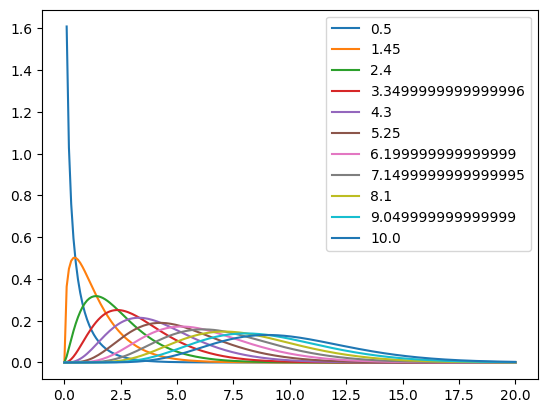

In [21]:
import matplotlib. pyplot as plt
import numpy as np
from scipy. stats import gamma
from sklearn.model_selection import train_test_split

import scipy.stats as stats
from matplotlib import pyplot as plt

alphas = np.linspace(0.5, 10,11)
print(alphas)
x = np.linspace (0, 20, 200)
for alpha in alphas:
    y1 = stats.gamma.pdf(x, a=alpha, scale=1) #a is alpha, loc is beta???
    plt.plot(x, y1, label=str(alpha))
    plt.legend()



In [22]:
# Main script for covariate shift



In [23]:
# Testing and graphs

import pandas as pd

def plot_ci(predictions, lower, upper, true_value=None, categories=None):
    """
    Plots confidence intervals of a predictor. Predictions and widths should be the same type/dimensional array.


    predictions: array of predictions of length l
    lower: array of lower confidence interval estimates of predictions of length l
    upper: array of upper confidence interval estimates of predictions of length l
    true_value (optional): true value of prediction, if available
    categories (optional): list of names of methods
    """
    predictions = np.array(predictions).flatten()
    lower = np.array(lower).flatten()
    upper = np.array(upper).flatten()
    df = {}

    if categories:
        df['method'] = categories
    
    df['lower'] = lower
    df['upper'] = upper

    df = pd.DataFrame(df)

    for lower,upper,y in zip(df['lower'],df['upper'],range(len(df))):
        plt.plot((lower,upper),(y,y),'ro-',color='orange')

    if true_value:
        plt.axvline(x = true_value, ls='--', label = 'True value')
    
    if categories:
        plt.yticks(range(len(df)),list(df['category']))

    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')


/tmp/ipykernel_1700/1176218869.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


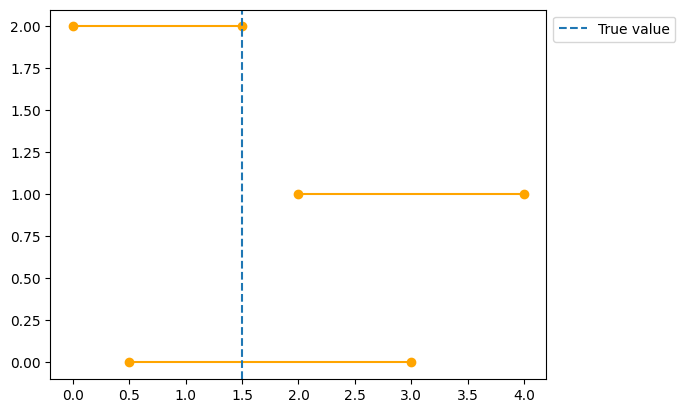

In [24]:
preds = np.array([[2, 3, 1]])
lower = [0.5, 2, 0]
upper = [3, 4, 1.5]

plot_ci(preds, lower, upper, true_value=1.5)

The following is a simple experiment, where we suppose we have two initial gamma distributions, $\mathbb{P}^u = 
\mathbb{P}^\ell$, with certain parameters. We will generate our training set $y = mx + 
\varepsilon$, here we will choose $\varepsilon \sim N(0, \sigma)$ for some small $\sigma$. We will train a model (probabily linear regression), then perform PPI, naive imputation, and classical (TBD what classical will be). We will also sample the true $y$ values, but the ML model will not be able to peek at it. 

Predicted:  [4.23082632] CI:  (array([3.84672785]), array([4.61492478])) Rectifier:  -0.25150303814432784 True mean:  4.0


/tmp/ipykernel_1700/1176218869.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


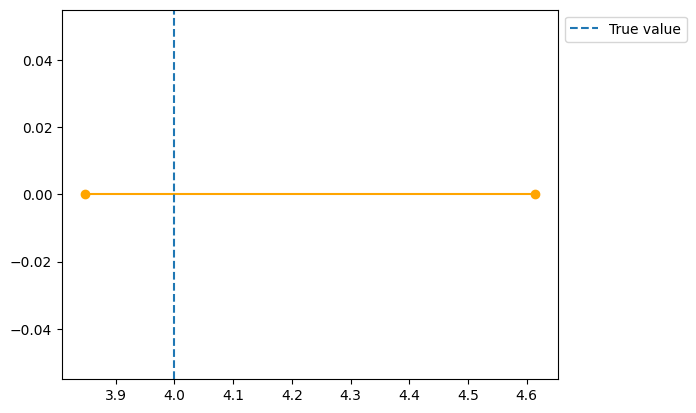

In [25]:
# PPI Testing, experiment 0, single test

import sklearn.model_selection


preds = []
lowers = []
uppers = []
residuals = []

# Generate training set
# Parameters

# Gamma dist, note the parameter names are not usual, k, theta is more usual

alpha = 1.0
beta = 2.0

# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho = 0.9 # 0 < rho <= 1 the smaller the rho, the more noise

# Sampling

x_train, y_train = sample_gamma_population(alpha, beta, train_sample, m, rho)  

x_gold, y_gold = sample_gamma_population(alpha, beta, small_sample, m, rho)

x_ppi, y_ppi = sample_gamma_population(alpha, beta, large_sample, m, rho)

# Reshaping for scikitlearn

x_train, y_train = np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
x_gold, y_gold = np.array(x_gold).reshape(-1, 1), np.array(y_gold).reshape(-1, 1)
x_ppi, y_ppi = np.array(x_ppi).reshape(-1, 1), np.array(y_ppi).reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

model = build_fit_slr(x_train, y_train)  # Training

# Residual testing

y_test_pred = model.predict(x_test)
residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
residuals.append(residual)

y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
y_fitted = model.predict(x_ppi)  # Unlabelled fitted

# Manual rectifier computation
rectifier = np.mean(y_gold_fitted - y_gold)

theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted)
theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted)


preds.append(theta)
lowers.append(theta_ci[0])
uppers.append(theta_ci[1])
true_mean = m * alpha * beta


plot_ci(preds, lowers, uppers, true_value=true_mean)

print("Predicted: ", theta, "CI: ", theta_ci, "Rectifier: ", rectifier, "True mean: ", true_mean)

In [26]:
# PPI Testing, experiment 0, multi-test

preds = []
lowers = []
uppers = []
true_bias = []
residuals = []
covered = []

# Generate training set
# Parameters

# Gamma dist, note the parameter names are not usual, k, theta is more usual

alpha = 1.0
beta = 2.0

# Population samples

train_size = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho = 0.9 # 0 < rho <= 1 the smaller the rho, the more noise

# Iterations

n_its = 10000

for i in range(n_its):
    # Sampling

    x_train, y_train = sample_gamma_population(alpha, beta, train_sample, m, rho)  

    x_gold, y_gold = sample_gamma_population(alpha, beta, small_sample, m, rho)

    x_ppi, y_ppi = sample_gamma_population(alpha, beta, large_sample, m, rho)

    # Reshaping for scikitlearn

    x_train, y_train = np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
    x_gold, y_gold = np.array(x_gold).reshape(-1, 1), np.array(y_gold).reshape(-1, 1)
    x_ppi, y_ppi = np.array(x_ppi).reshape(-1, 1), np.array(y_ppi).reshape(-1, 1)

    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

    model = build_fit_slr(x_train, y_train)  # Training

    # Residual testing

    y_test_pred = model.predict(x_test)
    residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
    residuals.append(residual)

    y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
    y_fitted = model.predict(x_ppi)  # Unlabelled fitted

    # Manual rectifier computation
    rectifier = np.mean(y_gold_fitted - y_gold)
    

    theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted)
    theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted)


    preds.append(theta[0])
    lowers.append(theta_ci[0][0])
    uppers.append(theta_ci[1][0])
    true_bias.append(np.mean(y_fitted - y_ppi))
    if true_mean >= theta_ci[0][0] and true_mean <= theta_ci[1][0]:
        covered.append(1)
    else:
        covered.append(0)

print("Average residual: ", np.mean(residuals))
print("Average pred: ", np.mean(preds), "Average lower bound: ", np.mean(lowers), "Average upper bound: ", np.mean(uppers), "Covered percent: ", np.mean(covered))

Average residual:  2.6524056321176466
Average pred:  3.961586218666965 Average lower bound:  3.5247549939020013 Average upper bound:  4.398417443431927 Covered percent:  0.8593


Text(0.5, 1.0, 'Predictions')

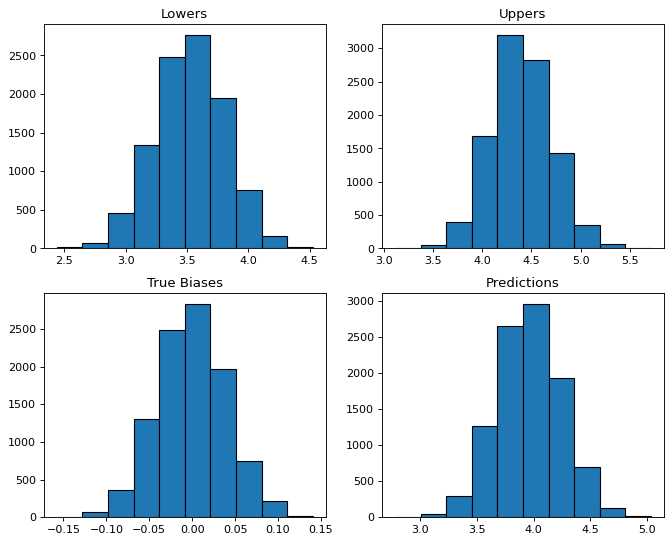

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=80)
axs[0, 0].hist(lowers, bins=10, edgecolor='black')
axs[0, 1].hist(uppers, bins=10, edgecolor='black')
axs[1, 0].hist(true_bias, bins=10, edgecolor='black')
axs[1, 1].hist(preds, bins=10, edgecolor='black')

axs[0, 0].set_title('Lowers')
axs[0, 1].set_title('Uppers')
axs[1, 0].set_title('True Biases')
axs[1, 1].set_title('Predictions')

In [28]:
# Naive imputation

# PPI Testing, experiment 0, multi-test

preds = []
lowers = []
uppers = []
true_bias = []
covered = []

# Generate training set
# Parameters

# Gamma dist, note the parameter names are not usual, k, theta is more usual

alpha = 1.0
beta = 2.0

# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho = 0.9 # 0 < rho <= 1 the smaller the rho, the more noise

# Iterations

n_its = 10000

for i in range(n_its):
    # Sampling

    x_train, y_train = sample_gamma_population(alpha, beta, train_sample, m, rho)  

    x_gold, y_gold = sample_gamma_population(alpha, beta, small_sample, m, rho)

    x_ppi, y_ppi = sample_gamma_population(alpha, beta, large_sample, m, rho)

    # Reshaping for scikitlearn

    x_train, y_train = np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
    x_gold, y_gold = np.array(x_gold).reshape(-1, 1), np.array(y_gold).reshape(-1, 1)
    x_ppi, y_ppi = np.array(x_ppi).reshape(-1, 1), np.array(y_ppi).reshape(-1, 1)

    model = build_fit_slr(x_train, y_train)  # Training

    y_fitted = model.predict(x_ppi)  # Unlabelled fitted

    # Naive imputation
    concat = np.vstack((y_gold, y_fitted)).flatten()  # Concactenate samples
    theta = np.mean(concat)  # Compute mean
    sigma = np.std(concat)  # Compute std dev
    n = concat.shape[0]
    theta_ci = stats.norm.interval(0.95, loc=theta, scale=sigma/np.sqrt(n))  # Use norm as N is large

    preds.append(theta)
    lowers.append(theta_ci[0])
    uppers.append(theta_ci[1])
    if true_mean >= theta_ci[0] and true_mean <= theta_ci[1]:
        covered.append(1)
    else:
        covered.append(0)

print("Average pred: ", np.mean(preds), "Average lower bound: ", np.mean(lowers), "Average upper bound: ", np.mean(uppers), "Covered percent: ", np.mean(covered))

Average pred:  3.9999536543251772 Average lower bound:  3.9218034232269194 Average upper bound:  4.078103885423437 Covered percent:  0.9001


In [29]:
# Classical code

# Naive imputation

# PPI Testing, experiment 0, multi-test

preds = []
lowers = []
uppers = []
true_bias = []
covered = []

# Generate training set
# Parameters

# Gamma dist, note the parameter names are not usual, k, theta is more usual

alpha = 1.0
beta = 2.0

# Population samples

small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho = 0.9 # 0 < rho <= 1 the smaller the rho, the more noise

# Iterations

n_its = 10000

for i in range(n_its):
    x_gold, y_gold = sample_gamma_population(alpha, beta, small_sample, m, rho)  

    y_gold = np.array(y_gold).flatten()

    theta, se = np.mean(y_gold), stats.sem(y_gold)
    h = se * stats.t.ppf((1 + .95) / 2., n-1)  # Highly stolen code, uses t-dist here

    preds.append(theta)
    lowers.append(theta - h)
    uppers.append(theta + h)
    if true_mean >= theta - h and true_mean <= theta + h:
        covered.append(1)
    else:
        covered.append(0)


print("Average pred: ", np.mean(preds), "Average lower bound: ", np.mean(lowers), "Average upper bound: ", np.mean(uppers), "Covered percent: ", np.mean(covered))

Average pred:  4.003990634430713 Average lower bound:  3.0742486410767547 Average upper bound:  4.933732627784671 Covered percent:  0.9356


Eventually I will combine the code into 1 for a single test, that's on the TODO list. But for now, we have reported 4 metrics with 10 thousand iterations. This is an example where rho is relatively small, in this case, the data is actually quite nice, and the model should fit very nicely, so we should expect every method to test well. Here are a summary of the results:


Classical always contained the train mean, and the the predicted mean even with 100 samples, was enough. With a t distribution confidence interval, we are able to contain the true parameter 100% of the time. The average confidence interval however, is quite large. This is to be expected with a small sample. 

Naive imputation actually performed the best, here because the model performs really well and the model is really simple (I think?). 

PPI kind of gets the best of both worlds. 

I'll finish writing this up later.

Rho:  0.1
Average residual:  1119.6852650056992
PPI. Average pred:  2.6356043579799984 Average lower bound:  -176.5008088543328 Average upper bound:  181.7720175702928 Average width:  358.27282642462563 Covered percent:  0.8996
Naive. Average pred:  4.0230753731525795 Average lower bound:  2.1563842316453172 Average upper bound:  5.88976651465984 Average width:  3.7333822830145227 Covered percent:  0.1198
Classical. Average pred:  2.630515459508503 Average lower bound:  -179.47751639205129 Average upper bound:  184.7385473110683 Average width:  364.2160637031196 Covered percent:  0.9053
Rho:  0.5
Average residual:  33.93435440868424
PPI. Average pred:  3.9667066045896964 Average lower bound:  -1.437268349941773 Average upper bound:  9.370681559121167 Average width:  10.807949909062938 Covered percent:  0.8828
Naive. Average pred:  4.007167465036421 Average lower bound:  3.920932760821758 Average upper bound:  4.093402169251084 Average width:  0.17246940842932612 Covered percent:  0.178

Text(0.5, 1.0, 'Confidence Interval Widths vs Amount of noise')

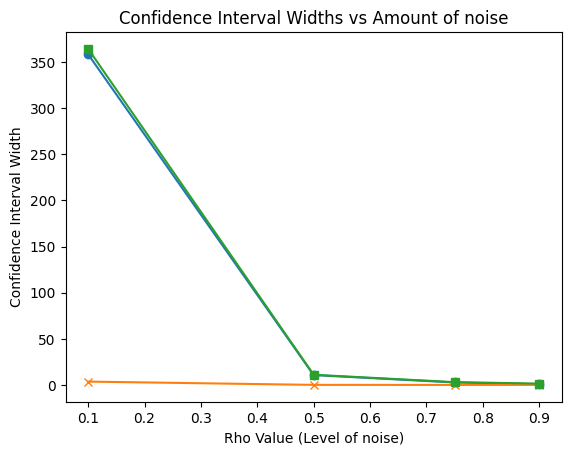

In [30]:
# Full experiment

# Gamma dist, note the parameter names are not usual, k, theta is more usual

alpha = 1.0
beta = 2.0

# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho_vals = [0.1, 0.5, 0.75, 0.90]

ppi_mean_widths = []
naive_mean_widths = []
classical_mean_widths = []


# Iterations

n_its = 10000

true_value = m * alpha * beta

for r in rho_vals:
    rho = r

    ppi_preds = []
    ppi_lowers = []
    ppi_uppers = []
    ppi_true_bias = []
    ppi_covered = []

    naive_preds = []
    naive_lowers = []
    naive_uppers = []
    naive_covered = []

    classical_preds = []
    classical_lowers = []
    classical_uppers = []
    classical_covered = []

    ppi_widths = []
    naive_widths = []
    classical_widths = []

    residuals = []

    
    for i in range(n_its):
        # Sampling

        x_train, y_train = sample_gamma_population(alpha, beta, train_sample, m, rho) 

        x_gold, y_gold = sample_gamma_population(alpha, beta, small_sample, m, rho)

        x_ppi, y_ppi = sample_gamma_population(alpha, beta, large_sample, m, rho)

        # Reshaping for scikitlearn

        x_train, y_train = np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
        x_gold, y_gold = np.array(x_gold).reshape(-1, 1), np.array(y_gold).reshape(-1, 1)
        x_ppi, y_ppi = np.array(x_ppi).reshape(-1, 1), np.array(y_ppi).reshape(-1, 1)

        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

        model = build_fit_slr(x_train, y_train)  # Training

        # Residual testing

        y_test_pred = model.predict(x_test)
        residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
        residuals.append(residual)

        y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
        y_fitted = model.predict(x_ppi)  # Unlabelled fitted

        # Manual rectifier computation
        rectifier = np.mean(y_gold_fitted - y_gold)

        # PPI section 

        ppi_theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted)
        ppi_theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted)


        ppi_preds.append(ppi_theta[0])
        ppi_lowers.append(ppi_theta_ci[0][0])
        ppi_uppers.append(ppi_theta_ci[1][0])
        ppi_true_bias.append(np.mean(y_fitted - y_ppi))
        if true_mean >= ppi_theta_ci[0][0] and true_mean <= ppi_theta_ci[1][0]:
            ppi_covered.append(1)
        else:
            ppi_covered.append(0)
        ppi_widths.append(ppi_theta_ci[1][0] - ppi_theta_ci[0][0])

        # Naive imputation
        concat = np.vstack((y_gold, y_fitted)).flatten()  # Concactenate samples
        naive_theta = np.mean(concat)  # Compute mean
        naive_sigma = np.std(concat)  # Compute std dev
        n_tot = concat.shape[0]
        naive_theta_ci = stats.norm.interval(0.9, loc=naive_theta, scale=naive_sigma/np.sqrt(n_tot))  # Use norm as N is large

        naive_preds.append(naive_theta)
        naive_lowers.append(naive_theta_ci[0])
        naive_uppers.append(naive_theta_ci[1])
        if true_mean >= naive_theta_ci[0] and true_mean <= naive_theta_ci[1]:
            naive_covered.append(1)
        else:
            naive_covered.append(0)
        naive_widths.append(naive_theta_ci[1] - naive_theta_ci[0])

        # Classical prediction (Gold standard only)
        
        classical_theta, classical_se = np.mean(y_gold.flatten()), stats.sem(y_gold.flatten())
        h = classical_se * stats.t.ppf((1 + .9) / 2., small_sample-1)  # Highly stolen code, uses t-dist here

        classical_preds.append(classical_theta)
        classical_lowers.append(classical_theta - h)
        classical_uppers.append(classical_theta + h)
        if true_mean >= classical_theta - h and true_mean <= classical_theta + h:
            classical_covered.append(1)
        else:
            classical_covered.append(0)
        classical_widths.append(2 * h)

    print("Rho: ", rho)
    print("Average residual: ", np.mean(residuals))
    print("PPI.", "Average pred: ", np.mean(ppi_preds), "Average lower bound: ", np.mean(
        ppi_lowers), "Average upper bound: ", np.mean(ppi_uppers), "Average width: ", np.mean(ppi_widths), "Covered percent: ", np.mean(ppi_covered))
    print("Naive.", "Average pred: ", np.mean(naive_preds), "Average lower bound: ", np.mean(
        naive_lowers), "Average upper bound: ", np.mean(naive_uppers), "Average width: ", np.mean(naive_widths), "Covered percent: ", np.mean(naive_covered))
    print("Classical.",  "Average pred: ", np.mean(classical_preds), "Average lower bound: ", np.mean(
        classical_lowers), "Average upper bound: ", np.mean(classical_uppers), "Average width: ", np.mean(classical_widths), "Covered percent: ", np.mean(classical_covered))
    
    ppi_mean_widths.append(np.mean(ppi_widths))
    naive_mean_widths.append(np.mean(naive_widths))
    classical_mean_widths.append(np.mean(classical_widths))

plt.figure()

# Plot each y against x
plt.plot(rho_vals, ppi_mean_widths, label='PPI Mean Widths', marker='o')
plt.plot(rho_vals, naive_mean_widths, label='Naive Mean Widths', marker='x')
plt.plot(rho_vals, classical_mean_widths, label='Classical Mean Widths', marker='s')

# Add labels and title
plt.xlabel('Rho Value (Level of noise)')
plt.ylabel('Confidence Interval Width')
plt.title('Confidence Interval Widths vs Amount of noise')


The better the residuals, aka the better the model fit, the better the CI's, sounds about right. In general, PPI outperforms classical, as we expected, when the model performs well. But it also performs about just as well, even when the model doesn't perform well. Don't use Naive, it's actually fake, unless the data is super super nice. But let's be honest here, real data is never nice.

Rho:  0.1
Average residual:  1119.965349228501 True bias : 0.4244072383152319
PPI. Average pred:  10.527811147770187 Average lower bound:  -2241.249162353432 Average upper bound:  2262.3047846489726 Average width:  4503.553947002404 Covered percent:  0.8907
Naive. Average pred:  29.018529988757496 Average lower bound:  6.496419654894567 Average upper bound:  51.54064032262042 Average width:  45.044220667725845 Covered percent:  0.0906
Classical. Average pred:  10.562003751592275 Average lower bound:  -2275.007233115116 Average upper bound:  2296.131240618301 Average width:  4571.1384737334165 Covered percent:  0.8961
Rho:  0.5
Average residual:  33.89211900141374 True bias : 0.015751243056624113
PPI. Average pred:  27.046147037820255 Average lower bound:  -41.15602218931158 Average upper bound:  95.2483162649521 Average width:  136.40433845426367 Covered percent:  0.8946
Naive. Average pred:  27.03416933255025 Average lower bound:  26.304549995518848 Average upper bound:  27.7637886695

Text(0.5, 1.0, 'Confidence Interval Widths vs Amount of noise')

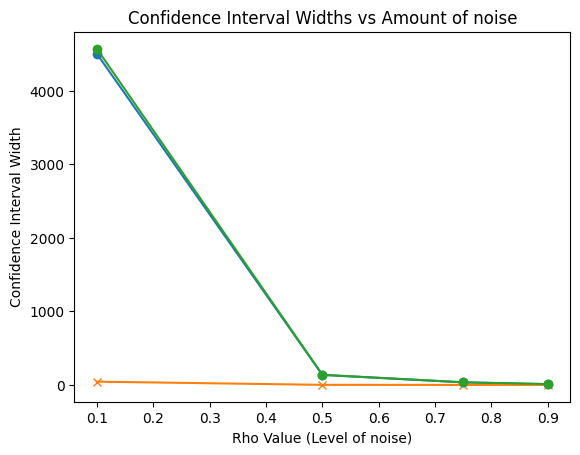

In [31]:
# Experiment 1, different distribution, simplest setting, univariate

# Gamma dist, note the parameter names are not usual, k, theta is more usual

# Training distribution

alpha_1 = 1.0 
beta_1 = 2.0

# PPI distribution

alpha_2 = 3.0
beta_2 = 4.5

# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho_vals = [0.1, 0.5, 0.75, 0.90]

ppi_mean_widths = []
naive_mean_widths = []
classical_mean_widths = []

# Iterations

n_its = 10000

true_mean = m * alpha_2 * beta_2

for r in rho_vals:
    rho = r

    ppi_preds = []
    ppi_lowers = []
    ppi_uppers = []
    ppi_true_bias = []
    ppi_covered = []
    ppi_widths = []

    naive_preds = []
    naive_lowers = []
    naive_uppers = []
    naive_covered = []
    naive_widths = []

    classical_preds = []
    classical_lowers = []
    classical_uppers = []
    classical_covered = []
    classical_widths = []

    residuals = []
    biases =[]
    for i in range(n_its):
        # Sampling

        x_train, y_train = sample_gamma_population(alpha_1, beta_1, train_sample, m, rho) 

        x_gold, y_gold = sample_gamma_population(alpha_2, beta_2, small_sample, m, rho)

        x_ppi, y_ppi = sample_gamma_population(alpha_2, beta_2, large_sample, m, rho)

        # Reshaping for scikitlearn

        x_train, y_train = np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
        x_gold, y_gold = np.array(x_gold).reshape(-1, 1), np.array(y_gold).reshape(-1, 1)
        x_ppi, y_ppi = np.array(x_ppi).reshape(-1, 1), np.array(y_ppi).reshape(-1, 1)

        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

        model = build_fit_slr(x_train, y_train)  # Training

        # Residual testing

        y_test_pred = model.predict(x_test)
        residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
        residuals.append(residual)

        y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
        y_fitted = model.predict(x_ppi)  # Unlabelled fitted

        # Manual rectifier computation
        rectifier = np.mean(y_gold_fitted - y_gold)

        # PPI section 

        ppi_theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted)
        ppi_theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted)


        ppi_preds.append(ppi_theta[0])
        ppi_lowers.append(ppi_theta_ci[0][0])
        ppi_uppers.append(ppi_theta_ci[1][0])
        ppi_true_bias.append(np.mean(y_fitted - y_ppi))
        if true_mean >= ppi_theta_ci[0][0] and true_mean <= ppi_theta_ci[1][0]:
            ppi_covered.append(1)
        else:
            ppi_covered.append(0)
        ppi_widths.append(ppi_theta_ci[1][0] - ppi_theta_ci[0][0])
        biases.append(np.mean(y_fitted - y_ppi))

        # Naive imputation
        concat = np.vstack((y_gold, y_fitted)).flatten()  # Concactenate samples
        naive_theta = np.mean(concat)  # Compute mean
        naive_sigma = np.std(concat)  # Compute std dev
        n_tot = concat.shape[0]
        naive_theta_ci = stats.norm.interval(0.9, loc=naive_theta, scale=naive_sigma/np.sqrt(n_tot))  # Use norm as N is large

        naive_preds.append(naive_theta)
        naive_lowers.append(naive_theta_ci[0])
        naive_uppers.append(naive_theta_ci[1])
        if true_mean >= naive_theta_ci[0] and true_mean <= naive_theta_ci[1]:
            naive_covered.append(1)
        else:
            naive_covered.append(0)
        naive_widths.append(naive_theta_ci[1] - naive_theta_ci[0])

        # Classical prediction (Gold standard only)
        
        classical_theta, classical_se = np.mean(y_gold.flatten()), stats.sem(y_gold.flatten())
        h = classical_se * stats.t.ppf((1 + .9) / 2., small_sample-1)  # Highly stolen code, uses t-dist here

        classical_preds.append(classical_theta)
        classical_lowers.append(classical_theta - h)
        classical_uppers.append(classical_theta + h)
        if true_mean >= classical_theta - h and true_mean <= classical_theta + h:
            classical_covered.append(1)
        else:
            classical_covered.append(0)
        classical_widths.append(2 * h)

    print("Rho: ", rho)
    print("Average residual: ", np.mean(residuals), "True bias :", np.mean(biases))
    print("PPI.", "Average pred: ", np.mean(ppi_preds), "Average lower bound: ", np.mean(
        ppi_lowers), "Average upper bound: ", np.mean(ppi_uppers), "Average width: ", np.mean(ppi_widths), "Covered percent: ", np.mean(ppi_covered))
    print("Naive.", "Average pred: ", np.mean(naive_preds), "Average lower bound: ", np.mean(
        naive_lowers), "Average upper bound: ", np.mean(naive_uppers), "Average width: ", np.mean(naive_widths), "Covered percent: ", np.mean(naive_covered))
    print("Classical.",  "Average pred: ", np.mean(classical_preds), "Average lower bound: ", np.mean(
        classical_lowers), "Average upper bound: ", np.mean(classical_uppers), "Average width: ", np.mean(classical_widths), "Covered percent: ", np.mean(classical_covered))

    ppi_mean_widths.append(np.mean(ppi_widths))
    naive_mean_widths.append(np.mean(naive_widths))
    classical_mean_widths.append(np.mean(classical_widths))

plt.figure()

plt.plot(rho_vals, ppi_mean_widths, label='PPI Mean Widths', marker='o')
plt.plot(rho_vals, naive_mean_widths, label='Naive Mean Widths', marker='x')
plt.plot(rho_vals, classical_mean_widths, label='Classical Mean Widths', marker='o')

# Add labels and title
plt.xlabel('Rho Value (Level of noise)')
plt.ylabel('Confidence Interval Width')
plt.title('Confidence Interval Widths vs Amount of noise')

Performs better than classical with data drift.

[(5.317400369498543, 1.026850476211198), (19.648785424212274, 17.924852696110403), (7.769558294997339, 15.563750545577884), (18.22933297578981, 13.60913712174835), (2.1778888535412007, 3.494266301378388), (5.475602388347011, 9.141770090185293), (16.813008806734032, 3.5951625521877686), (16.81191403838632, 7.68673675858521), (19.939304280544572, 13.45771132877269), (10.900154041742228, 9.5103105328854)]
Rho:  0.75
Average residual:  8.791137356327875 True bias : 0.0050853545424460415
PPI. Average pred:  10.9051845654651 Average lower bound:  9.364296594286955 Average upper bound:  12.446072536643246 Average width:  3.081775942356291 Covered percent:  0.8907
Naive. Average pred:  10.924657470454042 Average lower bound:  10.845567645736626 Average upper bound:  11.003747295171452 Average width:  0.15817964943482954 Covered percent:  0.1223
Classical. Average pred:  10.925942308287906 Average lower bound:  9.175507436351447 Average upper bound:  12.676377180224366 Average width:  3.5008697

ValueError: x and y must have same first dimension, but have shapes (4,) and (10,)

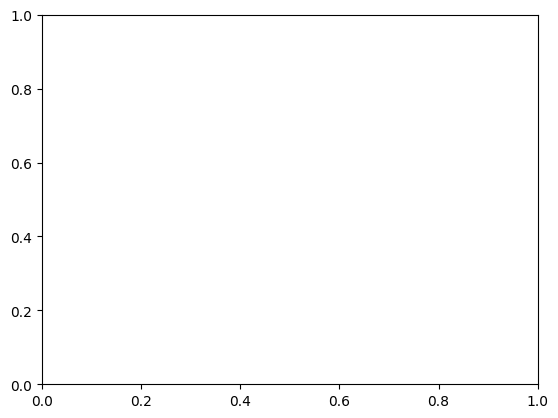

In [42]:
# Experiment 1, different distribution, simplest setting, univariate

# Gamma dist, note the parameter names are not usual, k, theta is more usual

# Training distribution

alpha_1 = 1.0 
beta_1 = 2.0


# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

m = 2.0
rho = 0.75

second_pop_params = np.random.uniform(low=0.1, high = 20, size=20)
second_pop_params = [(second_pop_params[i], second_pop_params[i+1]) for i in range(0, len(second_pop_params), 2)]
print(second_pop_params)


ppi_mean_widths = []
naive_mean_widths = []
classical_mean_widths = []


# Iterations

n_its = 10000

for params in second_pop_params:
    alpha_2, beta_2 = params
    true_mean = m * alpha_2 * beta_2

    ppi_preds = []
    ppi_lowers = []
    ppi_uppers = []
    ppi_true_bias = []
    ppi_covered = []
    ppi_widths = []

    naive_preds = []
    naive_lowers = []
    naive_uppers = []
    naive_covered = []
    naive_widths = []

    classical_preds = []
    classical_lowers = []
    classical_uppers = []
    classical_covered = []
    classical_widths = []

    ppi_widths = []
    naive_widths = []
    classical_widths = []

    residuals = []
    biases =[]
    for i in range(n_its):
        # Sampling

        x_train, y_train = sample_gamma_population(alpha_1, beta_1, train_sample, m, rho) 

        x_gold, y_gold = sample_gamma_population(alpha_2, beta_2, small_sample, m, rho)

        x_ppi, y_ppi = sample_gamma_population(alpha_2, beta_2, large_sample, m, rho)

        # Reshaping for scikitlearn

        x_train, y_train = np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1)
        x_gold, y_gold = np.array(x_gold).reshape(-1, 1), np.array(y_gold).reshape(-1, 1)
        x_ppi, y_ppi = np.array(x_ppi).reshape(-1, 1), np.array(y_ppi).reshape(-1, 1)

        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

        model = build_fit_slr(x_train, y_train)  # Training

        # Residual testing

        y_test_pred = model.predict(x_test)
        residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
        residuals.append(residual)

        y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
        y_fitted = model.predict(x_ppi)  # Unlabelled fitted

        # Manual rectifier computation
        rectifier = np.mean(y_gold_fitted - y_gold)

        # PPI section 

        ppi_theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted)
        ppi_theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted)


        ppi_preds.append(ppi_theta[0])
        ppi_lowers.append(ppi_theta_ci[0][0])
        ppi_uppers.append(ppi_theta_ci[1][0])
        ppi_true_bias.append(np.mean(y_fitted - y_ppi))
        if true_mean >= ppi_theta_ci[0][0] and true_mean <= ppi_theta_ci[1][0]:
            ppi_covered.append(1)
        else:
            ppi_covered.append(0)
        ppi_widths.append(ppi_theta_ci[1][0] - ppi_theta_ci[0][0])
        biases.append(np.mean(y_fitted - y_ppi))

        # Naive imputation
        concat = np.vstack((y_gold, y_fitted)).flatten()  # Concactenate samples
        naive_theta = np.mean(concat)  # Compute mean
        naive_sigma = np.std(concat)  # Compute std dev
        n_tot = concat.shape[0]
        naive_theta_ci = stats.norm.interval(0.9, loc=naive_theta, scale=naive_sigma/np.sqrt(n_tot))  # Use norm as N is large

        naive_preds.append(naive_theta)
        naive_lowers.append(naive_theta_ci[0])
        naive_uppers.append(naive_theta_ci[1])
        if true_mean >= naive_theta_ci[0] and true_mean <= naive_theta_ci[1]:
            naive_covered.append(1)
        else:
            naive_covered.append(0)
        naive_widths.append(naive_theta_ci[1] - naive_theta_ci[0])

        # Classical prediction (Gold standard only)
        
        classical_theta, classical_se = np.mean(y_gold.flatten()), stats.sem(y_gold.flatten())
        h = classical_se * stats.t.ppf((1 + .9) / 2., small_sample-1)  # Highly stolen code, uses t-dist here

        classical_preds.append(classical_theta)
        classical_lowers.append(classical_theta - h)
        classical_uppers.append(classical_theta + h)
        if true_mean >= classical_theta - h and true_mean <= classical_theta + h:
            classical_covered.append(1)
        else:
            classical_covered.append(0)
        classical_widths.append(2 * h)

    print("Rho: ", rho)
    print("Average residual: ", np.mean(residuals), "True bias :", np.mean(biases))
    print("PPI.", "Average pred: ", np.mean(ppi_preds), "Average lower bound: ", np.mean(
        ppi_lowers), "Average upper bound: ", np.mean(ppi_uppers), "Average width: ", np.mean(ppi_widths), "Covered percent: ", np.mean(ppi_covered))
    print("Naive.", "Average pred: ", np.mean(naive_preds), "Average lower bound: ", np.mean(
        naive_lowers), "Average upper bound: ", np.mean(naive_uppers), "Average width: ", np.mean(naive_widths), "Covered percent: ", np.mean(naive_covered))
    print("Classical.",  "Average pred: ", np.mean(classical_preds), "Average lower bound: ", np.mean(
        classical_lowers), "Average upper bound: ", np.mean(classical_uppers), "Average width: ", np.mean(classical_widths), "Covered percent: ", np.mean(classical_covered))

    ppi_mean_widths.append(np.mean(ppi_widths))
    naive_mean_widths.append(np.mean(naive_widths))
    classical_mean_widths.append(np.mean(classical_widths))

plt.figure()

# Plot each y against x
plt.plot(rho_vals, ppi_mean_widths, label='PPI Mean Widths', marker='o')
plt.plot(rho_vals, naive_mean_widths, label='Naive Mean Widths', marker='x')
plt.plot(rho_vals, classical_mean_widths, label='Classical Mean Widths', marker='s')

# Add labels and title
plt.xlabel('Rho Value (Level of noise)')
plt.ylabel('Confidence Interval Width')
plt.title('Confidence Interval Widths vs Amount of noise')

In [33]:
def sample_mv_y_linear(x, vec, beta, rho):
    sigma_squared = abs(m)*beta*(1.-(rho**2))/(rho**2)

    # sample noise (e_i)
    sampled_e = np.random.normal(loc=0,
                                 scale=sigma_squared,
                                 size=(x.shape[0], 1)
                                 )

    # compute y as a linear function of x
    y = x @ vec + sampled_e

    return y

def sample_mv_gamma_population(alpha, beta, sample_size, vec, rho=None):
    assert np.any(rho != 0), "rho must be different from 0"

    # sample x
    x = np.random.gamma(alpha, beta, (sample_size, vec.shape[0]))
    # sample y
    y = sample_mv_y_linear(x, vec, beta, rho)

    return x, y

In [34]:
# Create and fix a random vector
dims = 10
vec = np.random.uniform(low=-3, high=3, size=dims).reshape(-1, 1)
print(vec)

[[ 1.41357586]
 [ 0.15288522]
 [-2.81708228]
 [ 2.2859869 ]
 [ 2.52447638]
 [-0.77643728]
 [-1.9213408 ]
 [-1.57091931]
 [-2.17340916]
 [-1.71092065]]


In [35]:
# Experiment 1, different distribution, simplest setting, multivariate

# Gamma dist, note the parameter names are not usual, k, theta is more usual

# Training distribution

alpha_1 = 1.0 
beta_1 = 2.0


# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

vec = vec  # Don't ask why, this is just from the previous block
rho = 0.75

second_pop_params = [(3.0, 4.5), (10.0, 17.0), (50.0, 80.0), (100.0, 400.0)]

# Iterations

n_its = 1000

ppi_mean_widths = []
naive_mean_widths = []
classical_mean_widths = []

for params in second_pop_params:
    alpha_1, beta_2 = params

    ppi_preds = []
    ppi_lowers = []
    ppi_uppers = []
    ppi_true_bias = []
    ppi_covered = []
    ppi_widths = []

    naive_preds = []
    naive_lowers = []
    naive_uppers = []
    naive_covered = []
    naive_widths = []

    classical_preds = []
    classical_lowers = []
    classical_uppers = []
    classical_covered = []
    classical_widths = []


    residuals = []
    biases = []

    true_mean = alpha_2 * beta_2 * np.sum(vec)
    for i in range(n_its):
        # Sampling

        x_train, y_train = sample_mv_gamma_population(alpha_1, beta_1, train_sample, vec, rho) 

        x_gold, y_gold = sample_mv_gamma_population(alpha_2, beta_2, small_sample, vec, rho)

        x_ppi, y_ppi = sample_mv_gamma_population(alpha_2, beta_2, large_sample, vec, rho)


        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

        model = build_fit_slr(x_train, y_train)  # Training

        # Residual testing

        y_test_pred = model.predict(x_test)
        residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
        residuals.append(residual)

        y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
        y_fitted = model.predict(x_ppi)  # Unlabelled fitted

        # Manual rectifier computation
        rectifier = np.mean(y_gold_fitted - y_gold)

        # PPI section 

        ppi_theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted)
        ppi_theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted)


        ppi_preds.append(ppi_theta[0])
        ppi_lowers.append(ppi_theta_ci[0][0])
        ppi_uppers.append(ppi_theta_ci[1][0])
        ppi_true_bias.append(np.mean(y_fitted - y_ppi))
        if true_mean >= ppi_theta_ci[0][0] and true_mean <= ppi_theta_ci[1][0]:
            ppi_covered.append(1)
        else:
            ppi_covered.append(0)
        ppi_widths.append(ppi_theta_ci[1][0] - ppi_theta_ci[0][0])
        biases.append(np.mean(y_fitted - y_ppi))

        # Naive imputation
        concat = np.vstack((y_gold, y_fitted)).flatten()  # Concactenate samples
        naive_theta = np.mean(concat)  # Compute mean
        naive_sigma = np.std(concat)  # Compute std dev
        n_tot = concat.shape[0]
        naive_theta_ci = stats.norm.interval(0.9, loc=naive_theta, scale=naive_sigma/np.sqrt(n_tot))  # Use norm as N is large

        naive_preds.append(naive_theta)
        naive_lowers.append(naive_theta_ci[0])
        naive_uppers.append(naive_theta_ci[1])
        if true_mean >= naive_theta_ci[0] and true_mean <= naive_theta_ci[1]:
            naive_covered.append(1)
        else:
            naive_covered.append(0)
        naive_widths.append(naive_theta_ci[1] - naive_theta_ci[0])

        # Classical prediction (Gold standard only)
        
        classical_theta, classical_se = np.mean(y_gold.flatten()), stats.sem(y_gold.flatten())
        h = classical_se * stats.t.ppf((1 + .9) / 2., small_sample-1)  # Highly stolen code, uses t-dist here

        classical_preds.append(classical_theta)
        classical_lowers.append(classical_theta - h)
        classical_uppers.append(classical_theta + h)
        if true_mean >= classical_theta - h and true_mean <= classical_theta + h:
            classical_covered.append(1)
        else:
            classical_covered.append(0)
        classical_widths.append(2 * h)

    print("Rho: ", rho)
    print("Average residual: ", np.mean(residuals), "True bias :", np.mean(biases))
    print("PPI.", "Average pred: ", np.mean(ppi_preds), "Average lower bound: ", np.mean(
        ppi_lowers), "Average upper bound: ", np.mean(ppi_uppers), "Average width: ", np.mean(ppi_widths), "Covered percent: ", np.mean(ppi_covered))
    print("Naive.", "Average pred: ", np.mean(naive_preds), "Average lower bound: ", np.mean(
        naive_lowers), "Average upper bound: ", np.mean(naive_uppers), "Average width: ", np.mean(naive_widths), "Covered percent: ", np.mean(naive_covered))
    print("Classical.",  "Average pred: ", np.mean(classical_preds), "Average lower bound: ", np.mean(
        classical_lowers), "Average upper bound: ", np.mean(classical_uppers), "Average width: ", np.mean(classical_widths), "Covered percent: ", np.mean(classical_covered))

    ppi_mean_widths.append(np.mean(ppi_widths))
    naive_mean_widths.append(np.mean(naive_widths))
    classical_mean_widths.append(np.mean(classical_mean_widths))

Rho:  0.75
Average residual:  3.113850786478337 True bias : 0.13513238983540815
PPI. Average pred:  -2066.871471091237 Average lower bound:  -2072.57591910717 Average upper bound:  -2061.1670230753043 Average width:  11.40889603186589 Covered percent:  0.897
Naive. Average pred:  -2066.8496631276016 Average lower bound:  -2071.266290994929 Average upper bound:  -2062.433035260274 Average width:  8.833255734655173 Covered percent:  0.255
Classical. Average pred:  -2066.744727915578 Average lower bound:  -2111.5057182767205 Average upper bound:  -2021.9837375544357 Average width:  89.52198072228468 Covered percent:  0.899


/home/codespace/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/codespace/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Rho:  0.75
Average residual:  3.112497368612475 True bias : 0.4712806784415888
PPI. Average pred:  -7807.887622762583 Average lower bound:  -7829.618137127028 Average upper bound:  -7786.157108398139 Average width:  43.461028728889815 Covered percent:  0.877
Naive. Average pred:  -7807.677874513788 Average lower bound:  -7824.367991871543 Average upper bound:  -7790.987757156033 Average width:  33.38023471550975 Covered percent:  0.419
Classical. Average pred:  -7804.518722060115 Average lower bound:  -7973.321326745646 Average upper bound:  -7635.716117374584 Average width:  337.6052093710619 Covered percent:  0.911
Rho:  0.75
Average residual:  3.109521699752148 True bias : -0.21961837510581744
PPI. Average pred:  -36746.832101603344 Average lower bound:  -36849.381461113466 Average upper bound:  -36644.28274209322 Average width:  205.09871902024162 Covered percent:  0.896
Naive. Average pred:  -36745.93089636456 Average lower bound:  -36824.43675014795 Average upper bound:  -36667.4

Honestly about the same, except that when data becomes really deviated from the training data, PPI performs MUCH better than classical. Imputed still sucks and is unreliable, at least, until it's forced to give out really wide confidence intervals as well.

In [36]:
alpha = 1
beta = 1
sample_size = 10
x = np.random.gamma(alpha, beta, (50, 10))
x.shape

(50, 10)

In [38]:
def sample_mv_norm_gamma_population(alpha, beta, sample_size, vec):
    # sample x
    x = np.random.gamma(alpha, beta, (sample_size, vec.shape[0]))
    # sample y
    y = ((np.linalg.norm(x, axis=1)**2)/vec.shape[0]).reshape(-1,1)

    return x, y

In [39]:
# Experiment 1, different distribution, simplest setting, multivariate

# HORRENDOUSLY SLOW, PROCEED WITH CAUTION WHEN INCREASING N_ITS

# Gamma dist, note the parameter names are not usual, k, theta is more usual

# Training distribution
import time

alpha_1 = 1.0 
beta_1 = 2.0


# Population samples

train_sample = 10000
small_sample = 100
large_sample = 10000

# Linear sampling parameters

rho = 0.75

second_pop_params = [(3.0, 4.5), (10.0, 17.0), (50.0, 80.0), (100.0, 400.0)]

ppi_mean_widths = []
naive_mean_widths = []
classical_mean_widths = []

# Iterations

n_its = 10

for params in second_pop_params:
    alpha_1, beta_2 = params

    ppi_preds = []
    ppi_lowers = []
    ppi_uppers = []
    ppi_true_bias = []
    ppi_covered = []
    ppi_widths = []

    naive_preds = []
    naive_lowers = []
    naive_uppers = []
    naive_covered = []
    naive_widths = []

    classical_preds = []
    classical_lowers = []
    classical_uppers = []
    classical_covered = []
    classical_widths = []

    residuals = []
    biases = []

    true_mean = beta_2**2 * alpha_2 * (alpha_2 + 1)
    for i in range(n_its):
        # Sampling

        x_train, y_train = sample_mv_norm_gamma_population(alpha_1, beta_1, train_sample, vec) 

        x_gold, y_gold = sample_mv_norm_gamma_population(alpha_2, beta_2, small_sample, vec)

        x_ppi, y_ppi = sample_mv_norm_gamma_population(alpha_2, beta_2, large_sample, vec)


        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

        y_train, y_test = y_train.flatten(), y_test.flatten()

    
        start = time.time()
        
        model = build_fit_rf(x_train, y_train)  # Training, THIS TAKES TOO LONG, PLEASE FIX
        
        end = time.time()

        print(end - start)

        # Residual testing

        y_test_pred = model.predict(x_test)
        residual = np.sqrt(np.mean((y_test_pred - y_test)**2))  # Mean squared deviation
        residuals.append(residual)

        y_gold_fitted = model.predict(x_gold)  # Gold standard fitted
        y_fitted = model.predict(x_ppi)  # Unlabelled fitted

        # Manual rectifier computation
        rectifier = np.mean(y_gold_fitted - y_gold)

        # PPI section 

        ppi_theta = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_fitted, lhat=1)
        ppi_theta_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_fitted, lhat=1)


        ppi_preds.append(ppi_theta[0])
        ppi_lowers.append(ppi_theta_ci[0][0])
        ppi_uppers.append(ppi_theta_ci[1][0])
        ppi_true_bias.append(np.mean(y_fitted - y_ppi))
        if true_mean >= ppi_theta_ci[0][0] and true_mean <= ppi_theta_ci[1][0]:
            ppi_covered.append(1)
        else:
            ppi_covered.append(0)
        ppi_widths.append(ppi_theta_ci[1][0] - ppi_theta_ci[0][0])
        biases.append(np.mean(y_fitted - y_ppi))


        # Naive imputation
        concat = np.vstack((y_gold, y_fitted.reshape(-1,1))).flatten()  # Concactenate samples
        naive_theta = np.mean(concat)  # Compute mean
        naive_sigma = np.std(concat)  # Compute std dev
        n_tot = concat.shape[0]
        naive_theta_ci = stats.norm.interval(0.9, loc=naive_theta, scale=naive_sigma/np.sqrt(n_tot))  # Use norm as N is large

        naive_preds.append(naive_theta)
        naive_lowers.append(naive_theta_ci[0])
        naive_uppers.append(naive_theta_ci[1])
        if true_mean >= naive_theta_ci[0] and true_mean <= naive_theta_ci[1]:
            naive_covered.append(1)
        else:
            naive_covered.append(0)
        naive_widths.append(naive_theta_ci[1] - naive_theta_ci[0])


        # Classical prediction (Gold standard only)
        
        classical_theta, classical_se = np.mean(y_gold.flatten()), stats.sem(y_gold.flatten())
        h = classical_se * stats.t.ppf((1 + .9) / 2., small_sample-1)  # Highly stolen code, uses t-dist here

        classical_preds.append(classical_theta)
        classical_lowers.append(classical_theta - h)
        classical_uppers.append(classical_theta + h)
        if true_mean >= classical_theta - h and true_mean <= classical_theta + h:
            classical_covered.append(1)
        else:
            classical_covered.append(0)
        classical_widths.append(2 * h)

    print("Rho: ", rho)
    print("Average residual: ", np.mean(residuals), "True bias :", np.mean(biases))
    print("PPI.", "Average pred: ", np.mean(ppi_preds), "Average lower bound: ", np.mean(
        ppi_lowers), "Average upper bound: ", np.mean(ppi_uppers), "Average width: ", np.mean(ppi_widths), "Covered percent: ", np.mean(ppi_covered))
    print("Naive.", "Average pred: ", np.mean(naive_preds), "Average lower bound: ", np.mean(
        naive_lowers), "Average upper bound: ", np.mean(naive_uppers), "Average width: ", np.mean(naive_widths), "Covered percent: ", np.mean(naive_covered))
    print("Classical.",  "Average pred: ", np.mean(classical_preds), "Average lower bound: ", np.mean(
        classical_lowers), "Average upper bound: ", np.mean(classical_uppers), "Average width: ", np.mean(classical_widths), "Covered percent: ", np.mean(classical_covered))

    ppi_mean_widths.append(np.mean(ppi_widths))
    naive_mean_widths.append(np.mean(naive_widths))
    classical_mean_widths.append(np.mean(classical_mean_widths))
    
    

7.506728887557983
7.391922235488892
7.414770603179932
7.43609094619751
8.001906633377075
7.824939966201782
7.311866998672485
7.351037502288818
7.322725296020508
7.4171528816223145
Rho:  0.75
Average residual:  6.281389871660503 True bias : -204410.76747887168
PPI. Average pred:  204169.55543183727 Average lower bound:  202101.84932183655 Average upper bound:  206237.261541838 Average width:  4135.4122200014535 Covered percent:  0.9
Naive. Average pred:  2154.9987955010424 Average lower bound:  1823.7277047443538 Average upper bound:  2486.2698862577317 Average width:  662.542181513378 Covered percent:  0.0
Classical. Average pred:  204169.5554318373 Average lower bound:  202071.80234683206 Average upper bound:  206267.30851684258 Average width:  4195.506170010516 Covered percent:  0.9


/home/codespace/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/codespace/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6.128183603286743
6.184164762496948
6.172512531280518
6.253315448760986
5.969906806945801
6.341480493545532
6.159441709518433
6.305827379226685
6.229396343231201
6.221327066421509
Rho:  0.75
Average residual:  34.25506807422273 True bias : -2920187.2074566544
PPI. Average pred:  2924783.9409574717 Average lower bound:  2895238.674764979 Average upper bound:  2954329.2071499634 Average width:  59090.532384984755 Covered percent:  1.0
Naive. Average pred:  29729.89006717604 Average lower bound:  24982.523554020365 Average upper bound:  34477.256580331705 Average width:  9494.733026311345 Covered percent:  0.0
Classical. Average pred:  2924783.9409574717 Average lower bound:  2894809.336248013 Average upper bound:  2954758.5456669293 Average width:  59949.20941891566 Covered percent:  1.0
5.520986080169678
5.538261890411377
5.495684862136841
5.582061529159546
5.447874307632446
5.508261442184448
5.594995021820068
5.503378391265869
5.6855244636535645
5.771431922912598
Rho:  0.75
Average res

TODO: 
1) Find a way to make RF training not take 10 years

2) Make gamma distribution scale more slowly

3) Find a way to meaniningfully capture distance between two measures thats computationally cheap (TV, Wasserstein, etc)

4) Find new dataset, try survey or Titanic lmao